In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from utils import pareto_compare_plots, pareto_multicompare_plots, method_nice
from glob import glob
import pdb
import json
from tqdm import tqdm 
from collections import namedtuple
import numpy as np 

perf = namedtuple('perf',['method','dataset','seed'])
# rdir = 'results_r7'
rdirs = [
#     '../results_23-02-07/', 
#    '../results_combined/', 
#     '../fair_gp/analysis/results/'
    'results'
]
performances = {} 
methods = set()
datasets = set()
seeds = set()
seedcount = {}
from pathlib import Path
# for f in tqdm(glob(rdir+'/*.json')):
for rdir in rdirs:
    for f in Path(rdir).rglob('*.json'):

        with open(f) as fh:
            a = json.load(fh)
            method = a[0]['method']
            dataset = a[0]['dataset']
            seed = a[0]['seed']
            performances.update({perf(method,dataset,seed): a})
            methods.add(method)
            datasets.add(dataset)
            seeds.add(seed)
            if seed in seedcount:
                seedcount[seed] += 1
            else:
                seedcount[seed] = 1
        
print('methods:',methods)
print('datasets:',datasets)
print('seeds:',seeds)
all_methods = methods

methods: {'fomo_nsga2_lr_fnr'}
datasets: {'student'}
seeds: {42}


In [4]:
import pandas as pd
frames = []
for k,v in performances.items():
    frame = dict(
        method = k.method,
        dataset = k.dataset,
        seed = k.seed
    )
    frames.append(frame)
#     if k.method in summary.keys():
#         summary[k.method].append({k.seed: k.dataset})
#     else:
#         summary[k.method] = list({k.seed: k.dataset})
# summary
df = pd.DataFrame(frames)
df

,method,dataset,seed
0,fomo_nsga2_lr_fnr,student,42


In [5]:
for method,dfg in df.groupby('method'):
    display(dfg.value_counts())

method             dataset  seed
fomo_nsga2_lr_fnr  student  42      1
Name: count, dtype: int64

In [6]:
df.groupby(['method','seed'])['dataset'].value_counts().unstack()

,dataset,student
method,seed,
fomo_nsga2_lr_fnr,42,1


In [7]:
from utils import pareto_plots

# pareto_plots(performances[perf('fomo_nsga2_lr_fpr','lsac_bar',12669)])

In [8]:
from itertools import combinations
import matplotlib.pyplot as plt
i = 0
# for m1,m2 in combinations(methods,2):
m1,m2 = ('feat_random_p100_g0','fomo_nsga2_lr')
#     for d in datasets:
for d in ['adult']:
    for s in seeds:
#         for s in [4866]: 
        if perf(m1,d,s) in performances.keys() and perf(m2,d,s) in performances.keys():
            h = pareto_compare_plots(performances[perf(m1,d,s)],
                                 performances[perf(m2,d,s)],
                                 d)
            i += 1
#                 plt.close(h)

fomo_nsga2_lr_fnr:archive(0) 0.28829009858032234 0.007809449433814916
fomo_nsga2_lr_fnr:archive(1) 0.30078300197827695 0.005027333073018353
fomo_nsga2_lr_fnr:archive(2) 0.31347523420815265 0.0041975790706755165
fomo_nsga2_lr_fnr:archive(3) 0.28057878520207263 0.0042463881296368605
fomo_nsga2_lr_fnr:archive(4) 0.3287037642776003 0.004295197188598204
fomo_nsga2_lr_fnr:archive(5) 0.2952320106048626 0.004295197188598204
fomo_nsga2_lr_fnr:archive(6) 0.3087238104972511 0.004295197188598204
fomo_nsga2_lr_fnr:archive(7) 0.30277265146799803 0.00439281530652089
fomo_nsga2_lr_fnr:archive(8) 0.3294256785957916 0.003758297540023428
fomo_nsga2_lr_fnr:archive(9) 0.3059295350454118 0.00439281530652089
fomo_nsga2_lr_fnr:archive(10) 0.30091197488867044 0.00439281530652089
fomo_nsga2_lr_fnr:archive(11) 0.27467753822799346 0.0076630222569308865
fomo_nsga2_lr_fnr:archive(12) 0.316808136088769 0.004002342834830144


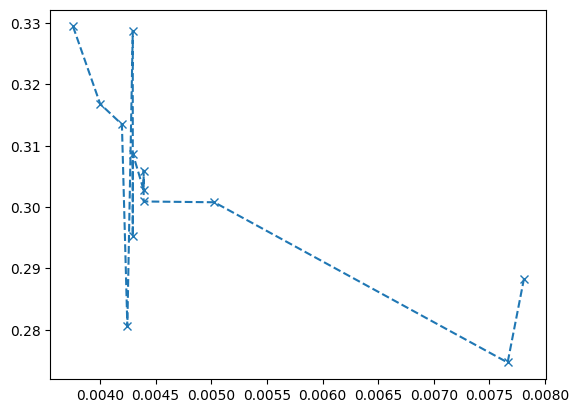

In [10]:
from utils import pareto_plot
# p= performances[perf('gerryfair_lr_fnr','adult',10197)]
p= performances[perf('fomo_nsga2_lr_fnr','student',42)]
# p= performances[perf('fomo_nsga2_lr_fpr','adult',10197)]

# pareto_plot(
#     p,
#     'auditor_fp_violation',
#     'auc_roc',
# #     'accuracy',
    
# #     'Subgroup FPR',
#     'AUROC',
#     '1-accuracy',
#     reverse_x = False, 
#     reverse_y = True
# )
fp, acc, auroc = [], [] ,[]
mae = []
for m in p:
    print(
        m['model'],
        m['train']['mae'],
#         m['train']['auditor_fp_violation'],
        m['train']['subgroup_fnr'],
#         m['train']['auc_roc']
    )
    model = m['model']
    fold = 'train'
    fp.append(m[fold]['subgroup_fnr'])
    mae.append(m[fold]['mae'])
    acc.append(m[fold]['accuracy'])
    auroc.append(m[fold]['auc_roc'])
mae = np.asarray(mae)
fp = np.asarray(fp)
acc = np.asarray(acc)
auroc = np.asarray(auroc)
s = np.argsort(fp)
# plt.plot(fp[s],[-a for a in auroc[s]],'--x')
plt.plot(fp[s],mae[s],'--x')


In [58]:
from utils import fair_metrics, loss_metrics, reverse_metrics, front
from itertools import chain
import numpy as np

def pareto_multicompare_plot(perfs, dataset_name,xname,yname,xname_nice,
        yname_nice, reverse_x = False, reverse_y = False, rdir='', h = None, count =0,
                             fold='test', trial=0
                            ):

    if h == None:
        h = plt.figure(figsize=(12,12))
    plt.gca().grid(True,axis='both')
    
    models = [p[0]['method'] for p in perfs]
    # keep only relevant models (based on FPR/FNR)
    metric_type = 'fnr' if 'fn' in xname else 'fpr'
    models = [m for m in models if metric_type in m]
    # sort results by name
    s = np.argsort([method_nice[m] for m in models])
    models = [models[i] for i in s]
    perfs = [perfs[i] for i in s]
   
#     print('models:',models)
    seed = perfs[0][0]['seed']
    for p in perfs:
        assert seed == p[0]['seed'] 
    seed = str(seed)
    
#     x_vals = {m:{'train':[], 'test':[]} for m in models}
#     y_vals = {m:{'train':[], 'test':[]} for m in models}
    
    x_vals = {m:[] for m in models}
    y_vals = {m:[] for m in models}
    
    for perf,m in zip(perfs,models):
        for i,p in enumerate(perf):
            x_vals[m].append(p[fold][xname])
            y_vals[m].append(p[fold][yname])
        
    if reverse_x: 
#         print('reversing x for ',xname)
        for m in models:
#             for t in ['train','test']:
            x_vals[m] = [1-x for x in x_vals[m]]
    if reverse_y: 
#         print('reversing y for ',yname)
        for m in models:
#             for t in ['train','test']:
            y_vals[m] = [1-y for y in y_vals[m]]
            
    # get pareto front
    pf_x = {}
    pf_y = {}
    for m in models:
        s = np.argsort(x_vals[m])
        x_vals[m] = np.array(x_vals[m])[s]
        y_vals[m] = np.array(y_vals[m])[s]
        
        pf_tmp = front(x_vals[m],y_vals[m])
        pf_x[m] = [x_vals[m][i] for i in pf_tmp]
        pf_y[m] = [y_vals[m][i] for i in pf_tmp]
        
#     # get the pareto front of the combined solutions
    all_x_vals = list(chain.from_iterable( x_vals[m] for m in models))
# #     all_x_vals_test = [ x_vals[m]['test'] for m in models]
    all_y_vals = list(chain.from_iterable( y_vals[m] for m in models))
# #     all_y_vals_test = [ y_vals[m]['test'] for m in models]
# #     print('all_x_vals_test:',all_x_vals_test)
# #     print('all_y_vals_test:',all_y_vals_test)
    PF = front(all_x_vals,all_y_vals)
    pf_x_vals = [all_x_vals[i] for i in PF]
    pf_y_vals = [all_y_vals[i] for i in PF]
    
#     for m in models:
# #         for t in ['train','test']:
#         x_vals[m] = np.array(x_vals[m])
#         y_vals[m] = np.array(y_vals[m])
            
#     pf_x = {}
#     pf_y = {}
#     for m in models:
#         pf_x[m] = [] #{'train':[],'test':[]}
#         pf_y[m] = [] #{'train':[],'test':[]}
# #         for t in ['train','test']:
#         pf_tmp = front(x_vals[m],y_vals[m])
#         pf_x[m] = [x_vals[m][i] for i in pf_tmp]
#         pf_y[m] = [y_vals[m][i] for i in pf_tmp]
            
    # make plots!
        
#     # pareto front line
    plt.plot(
        pf_x_vals, 
        pf_y_vals, 
        '-k', 
        linewidth=4,
        alpha=0.1, 
        label= '_no_legend'
    )
    cmap = plt.cm.get_cmap('tab20',len(models))
#     cmap = plt.cm.get_cmap('tab20',20)
    markers = ['x','s','^','d','*','+','v','>','<','D']*10
#     pdb.set_trace()
    for c,m in enumerate(models):
#         print(m)
#         plt.plot(
#             x_vals[m],
#             y_vals[m],
#             linestyle='',
#             marker=markers[c],
#             color=cmap(c),
#             # markerfacecolor='none',
#             # label=method_nice[m],
#             label=m,
#             # label='_no_legend',
#             alpha=1.0
#         )
        x = np.asarray(pf_x[m])
        y = np.asarray(pf_y[m])
        plt.plot(
#             x+np.random.normal(0,.001*np.mean(x)),
#             y+np.random.normal(0,.001*np.mean(y)),
            x,
            y,
            markers[c],
            color=cmap(c),
            markeredgecolor='k' if markers[c] not in ['x','+'] else cmap(c),
#             color=cmap(trial),
            linestyle='--',
            # markerfacecolor='none',
            label=method_nice[m],
#             label=m,
            # label='_no_legend',
            alpha=0.8
        )
#         plt.plot(
#             pf_x[m],
#             pf_y[m],
#             '--',
#             color=cmap(c),
#             label='_no_legend',
#             alpha=0.7
#         )
   
#     print('PF:',PF)
    plt.scatter(
        pf_x_vals, 
        pf_y_vals, 
        marker='o', 
        facecolors='none',
        edgecolor='k', 
        s=200, 
        label= 'Pareto front',
        alpha=0.5
    )
#     plt.gca().set_xscale('log')
#     plt.gca().set_yscale('log')
#     for i in np.arange(len(x_vals['train'])):
#         plt.plot([x_vals[fold][i] for t in ['train','test']],
#                  [y_vals[fold][i] for t in ['train','test']],
#                  ':',alpha=0.5,label='_no_legend')
    leg = plt.legend(loc=[1.01, 0.1])

    plt.title(f'dataset = {dataset_name} ') #| Trial {trial}')
    plt.xlabel(xname_nice)
    plt.ylabel(yname_nice)

    plt.tight_layout()
    if not os.path.exists(FIGDIR+rdir):
        os.makedirs(FIGDIR+rdir, exist_ok=True)
        
#     plt.gca().set_xscale('log')
#     plt.gca().set_yscale('log')
    savename = (
        FIGDIR+rdir
        +'/pareto_multicompare_'+xname+'-'+yname+'_'
        # +'_'+'-'.join([m for m in models])
        +f'_all_models'
        +f'_{fold}'
        +'_'+dataset_name
        +f'_{trial}'
    )
    print('saving ',savename)
    for ending in ['.png','.pdf']:
        plt.savefig(savename + ending, 
                    #bbox_extras=[leg], 
                    dpi=400)
    
    # return hypervolumes 
    return h

def pareto_multicompare_plots(perfs, dataset_name, fm = fair_metrics,
        lm = loss_metrics, rdir='', h=None, trial=0):
    for f,flabel in fm.items():
        for L,Llabel in lm.items():
            pareto_multicompare_plot(perfs, dataset_name, f, L, flabel, Llabel,
                               reverse_y = L in reverse_metrics, rdir=rdir, h=h, trial=trial)


saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_0
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_1
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_2
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_3
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_4
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_5
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_6
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fpr-auc_roc__all_models_test_adult_7
saving  ../../paper/figs/pareto/combined_comparison/pare

/tmp/ipykernel_602030/3174036274.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  h = plt.figure(figsize=(6,4))


saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_0
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_1
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_2
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_3
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_4
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_5
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_6
saving  ../../paper/figs/pareto/combined_comparison/pareto_multicompare_subgroup_fnr-auc_roc__all_models_test_adult_7
saving  ../../paper/figs/pareto/combined_comparison/pare

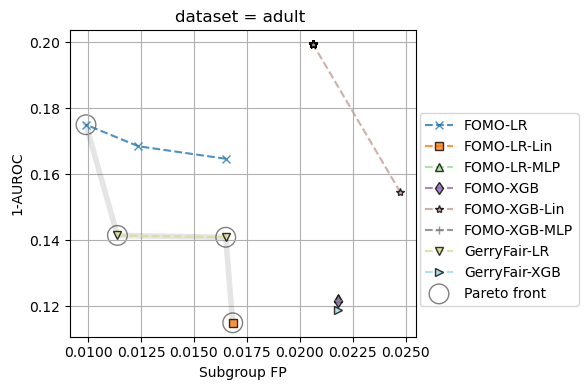

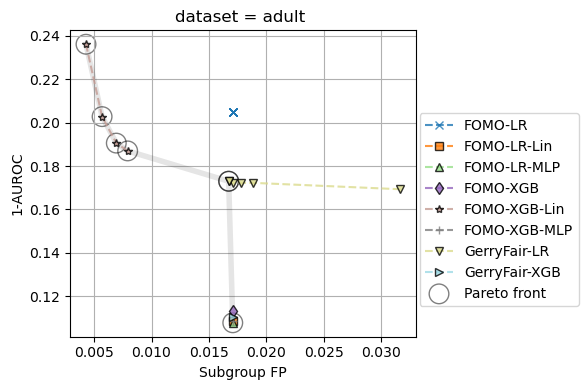

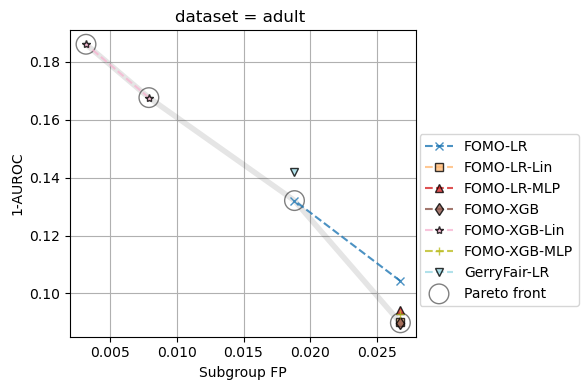

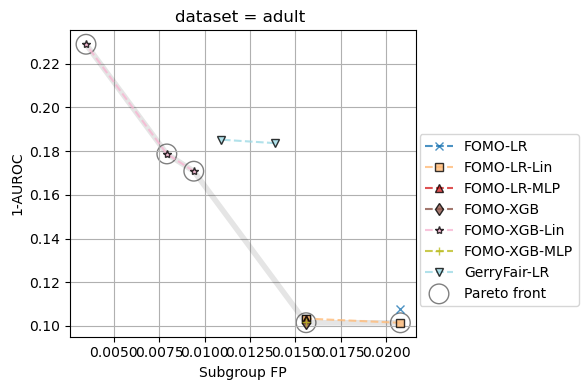

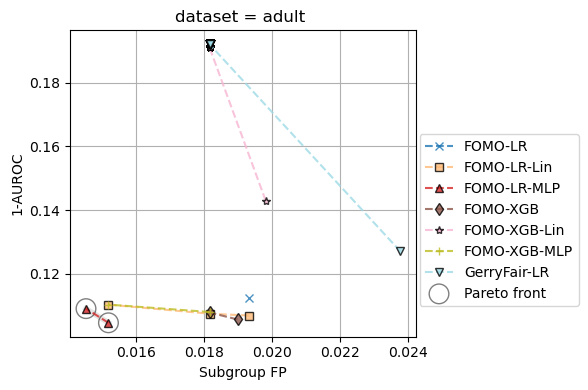

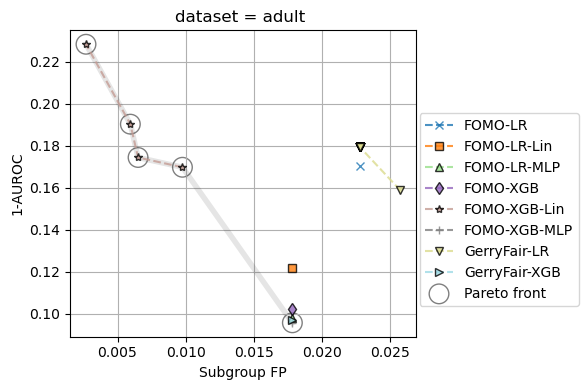

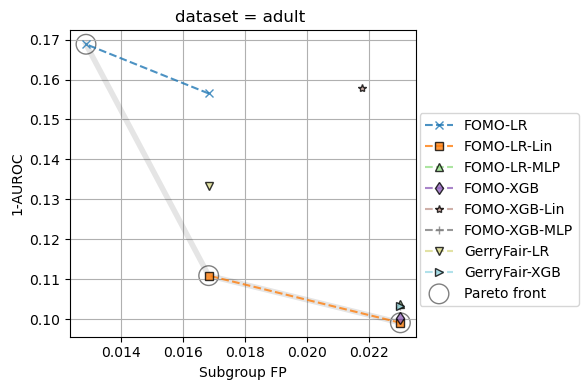

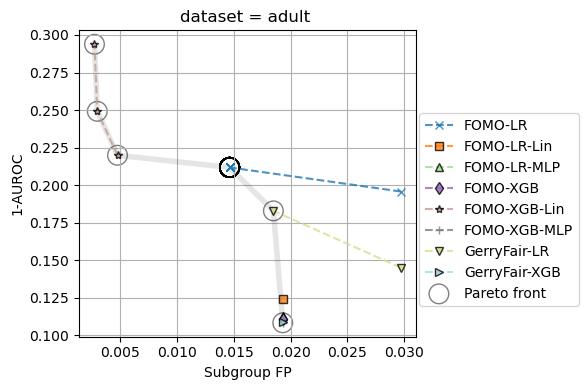

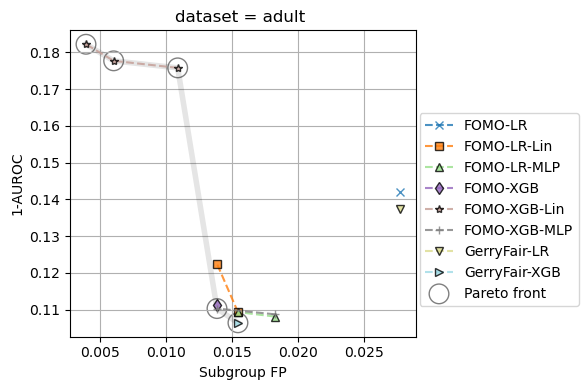

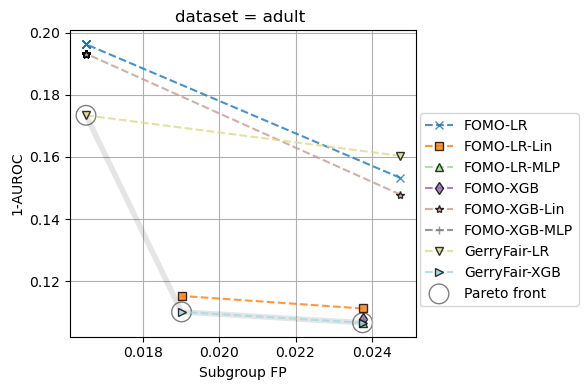

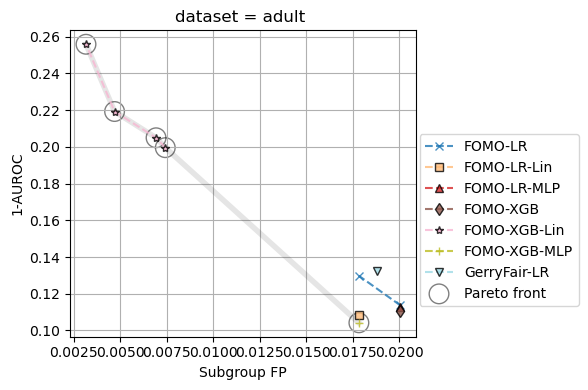

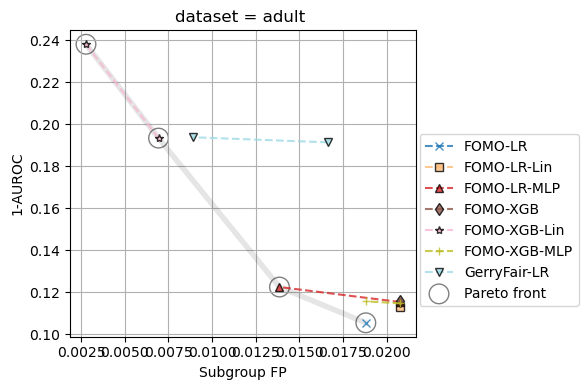

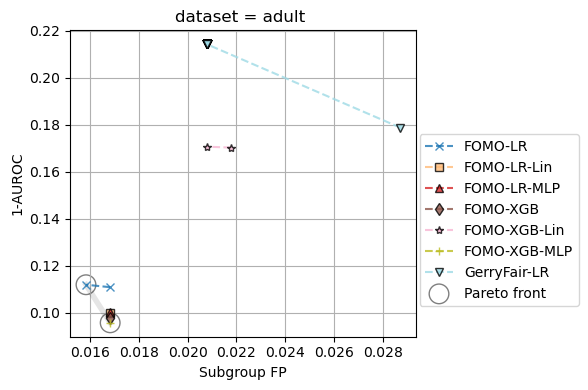

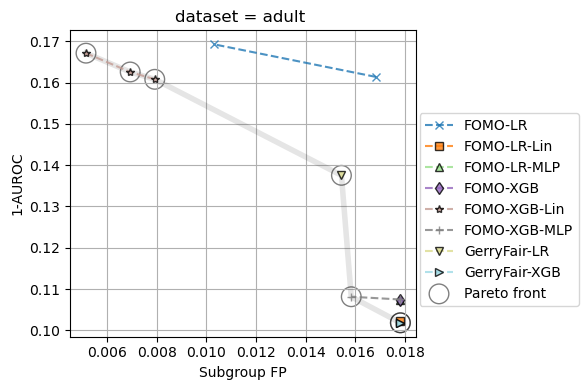

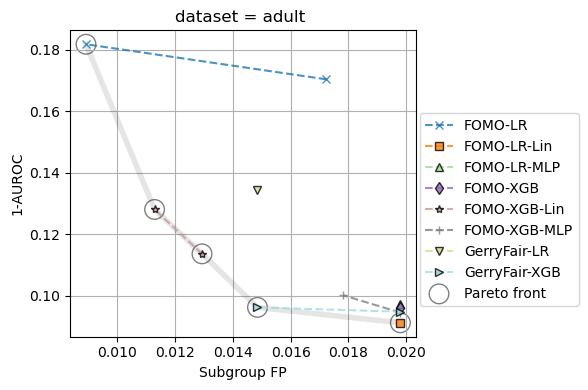

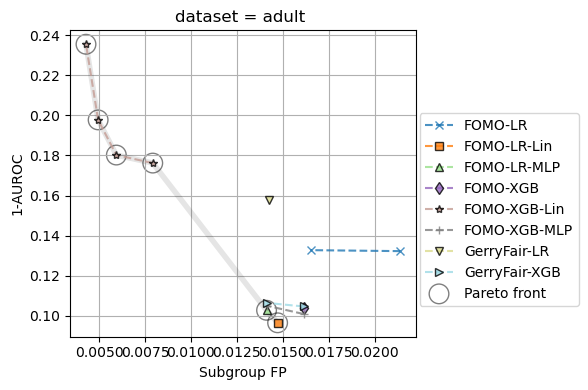

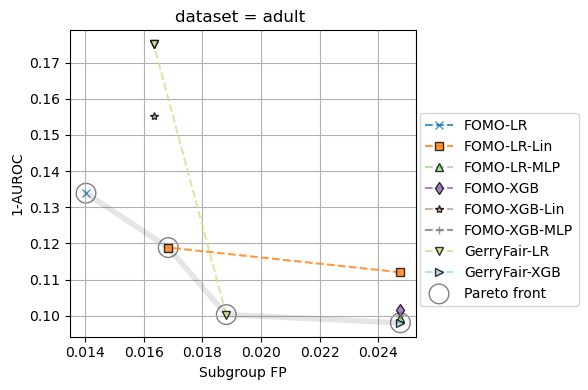

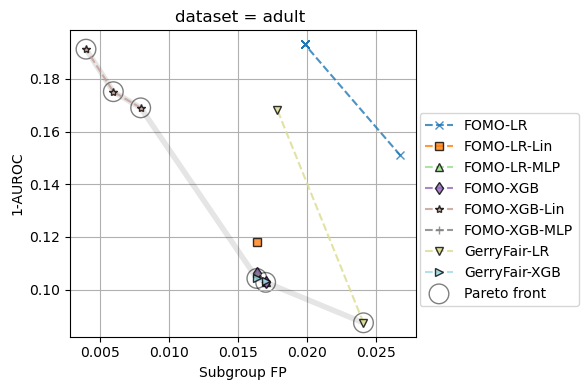

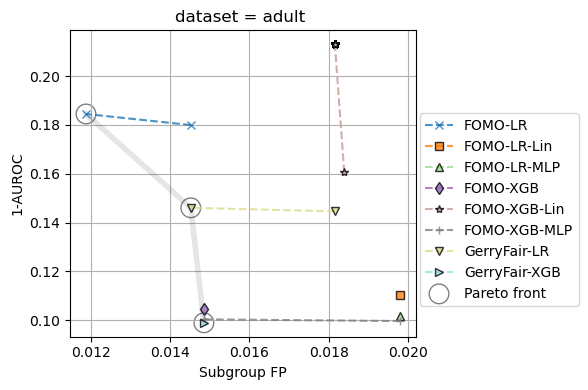

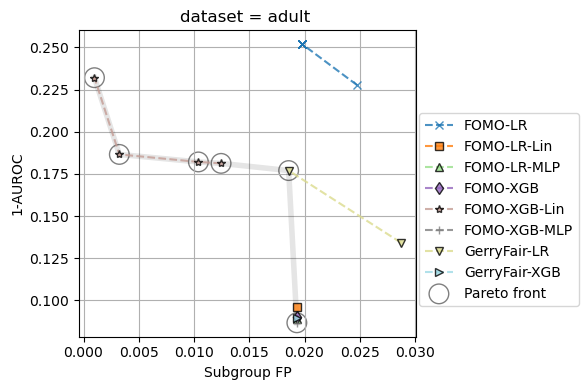

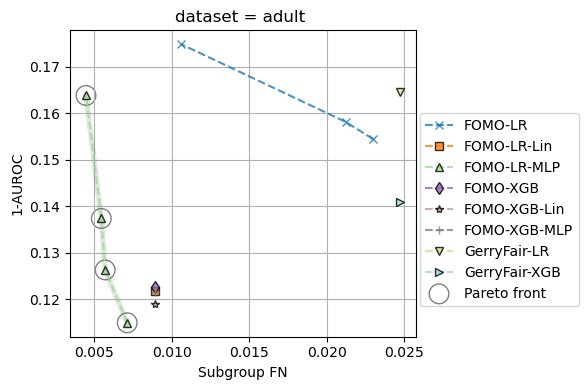

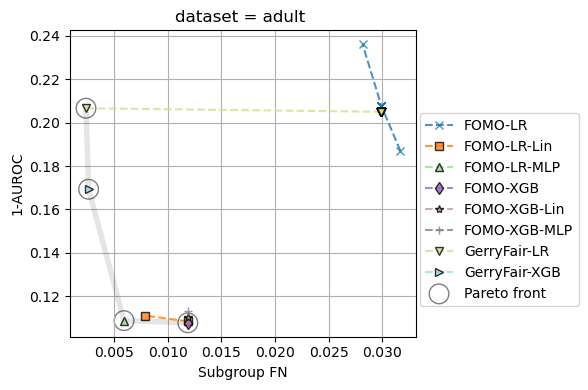

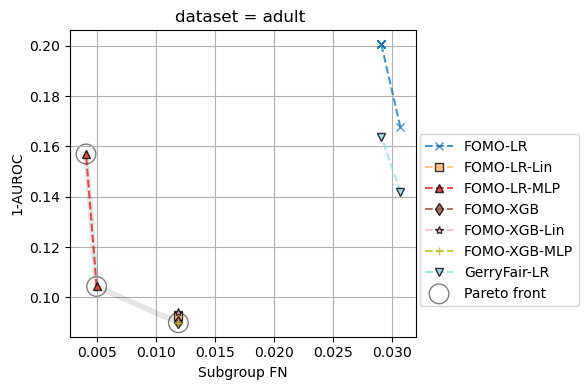

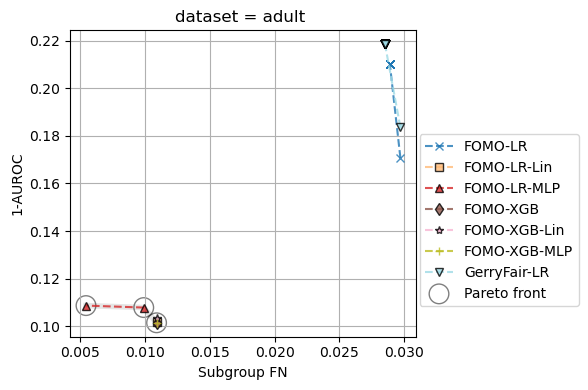

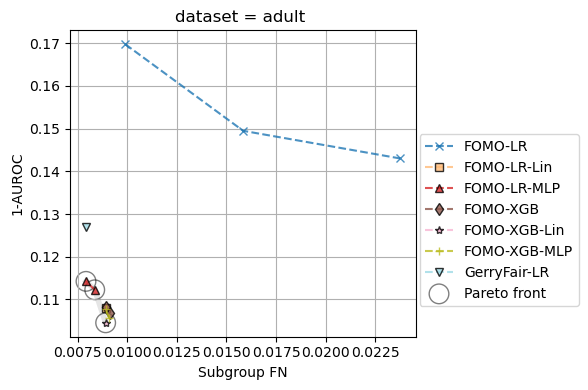

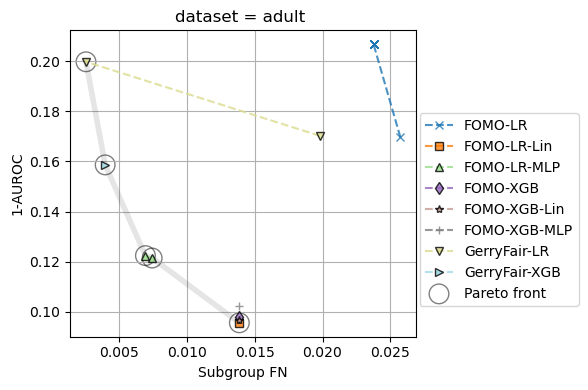

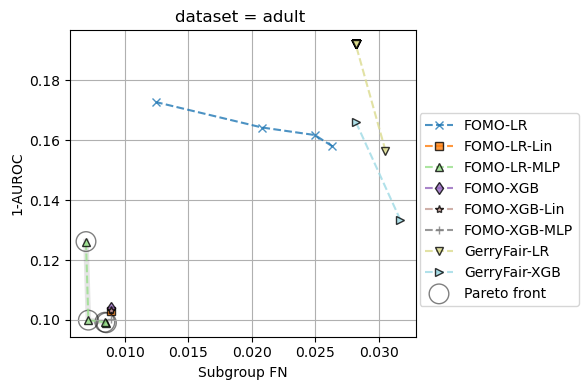

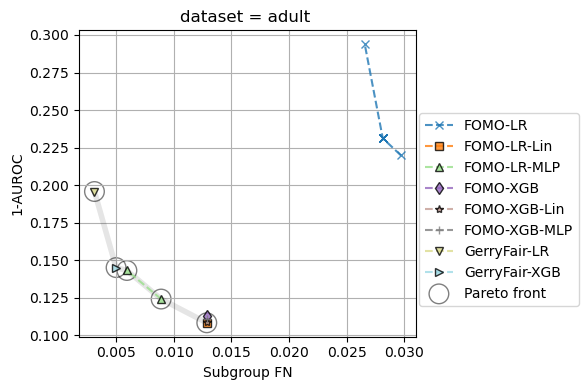

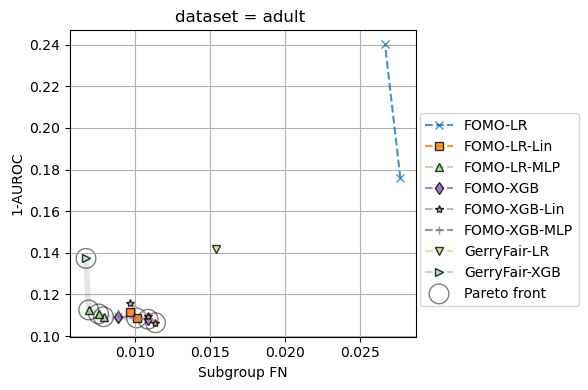

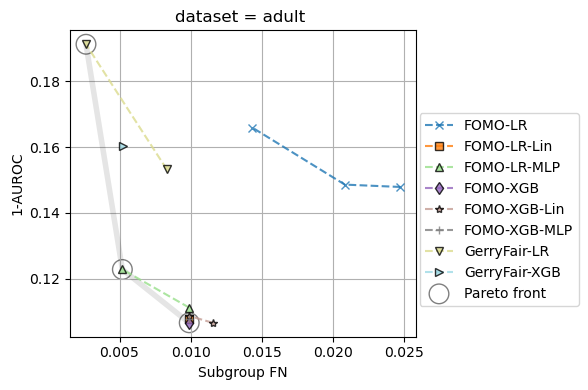

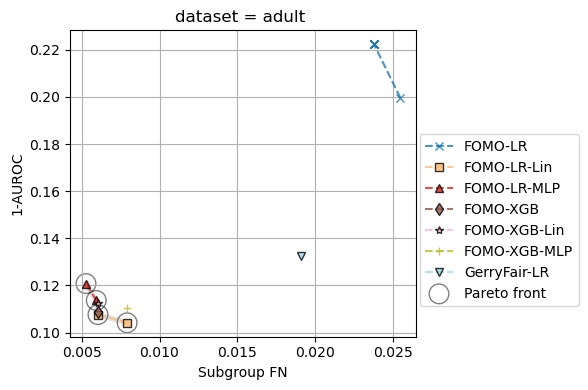

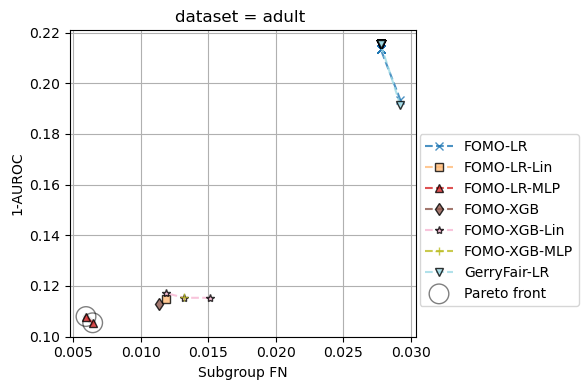

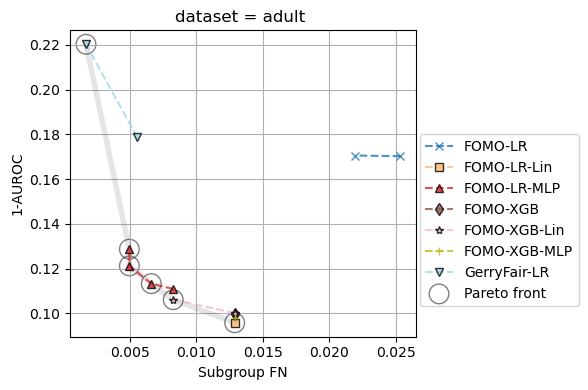

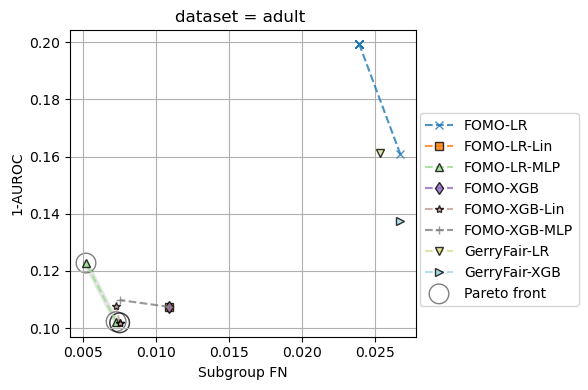

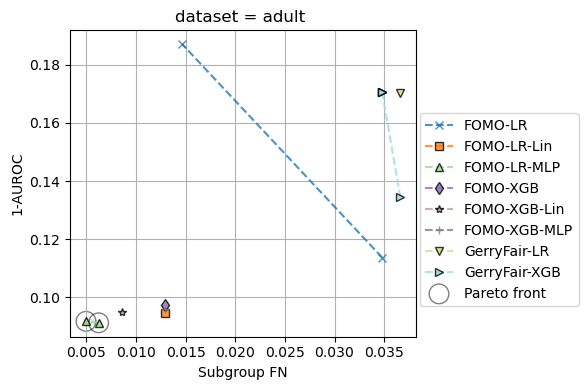

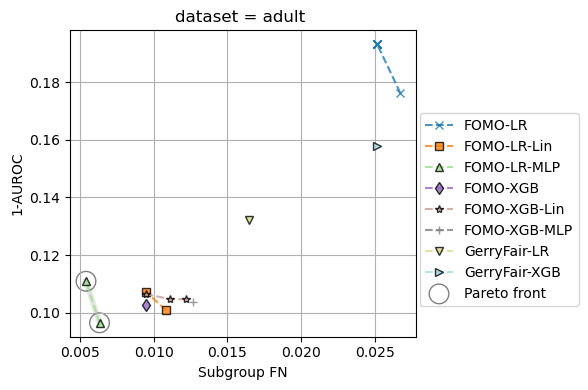

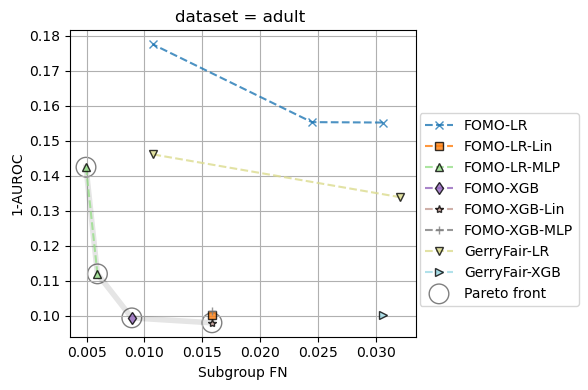

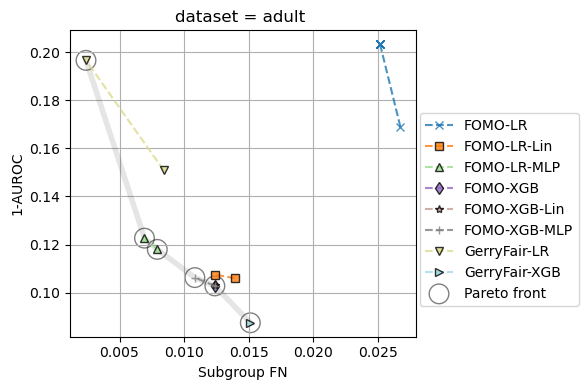

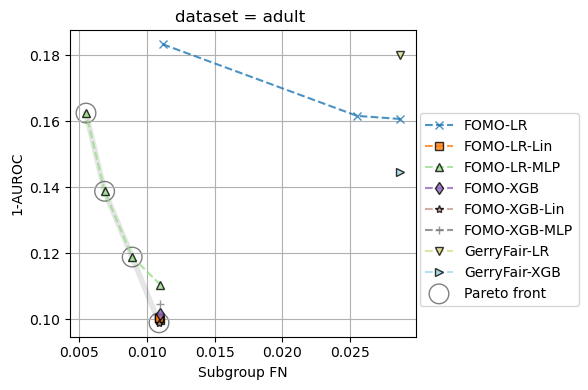

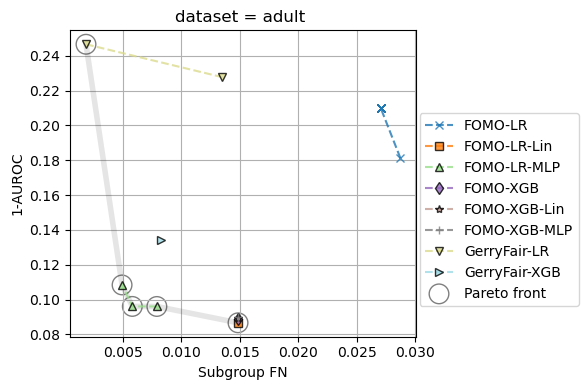

In [60]:
from itertools import combinations
import matplotlib.pyplot as plt
import os
FIGDIR = '../../paper/figs/pareto/'
# fm = {k:v for k,v in fair_metrics.items() if 'subgroup' in k}
lm = {k:v for k,v in loss_metrics.items() if k in ['mae','auc_roc']}
fm = {
#     'auditor_fp_violation':'Auditor FP violation',
    'subgroup_fpr':'Subgroup FP',
    'subgroup_fnr':'Subgroup FN',
}
lm = {
#     'mae':'MAE',
     'auc_roc':'1-AUROC'
     }
# methods = [
#     'fomo_nsga2_lr_fpr',
#     'gerryfair_lr_fpr'
# ]
methods = all_methods
countmax = 100
# for ml in ['lr','xgb']:
# for d in datasets:
#     if d in ['lsac_bar','communities','adult','lawschoo']: continue
for d in ['adult']:
# for d in ['lsac_bar']:
    for f,flabel in fm.items():
#     for f,flabel in fair_metrics.items():
#         for L,Llabel in loss_metrics.items():
        for L,Llabel in lm.items():
            count = 0
            for s in seeds:
                h = plt.figure(figsize=(6,4))
                if count >= countmax:
                    break
                keepgoing = True
                perfs = []
                for m in methods:
                    if perf(m,d,s) in performances.keys(): 
                        perfs.append(perf(m,d,s))
                    else:
                        keepgoing=False
#                 keepgoing=True
#                 if keepgoing:
                if len(perfs)>4:
                    pareto_multicompare_plot(
                        [performances[p] for p in perfs], 
                        d, 
                        f, 
                        L,
                        flabel,
                        Llabel,
                        reverse_y = L in reverse_metrics,
                        rdir='combined_comparison',
                        h = h,
                        fold='test',
                        trial=count
                    )
                    count += 1
